__I have included the grading rubric requirements in each section, the requirements are italicized throughout the document__

__1.) Project Topic__

*Is there a clear explanation of what this project is about? Does it state clearly which type of problem?<br>*
*Does it state the motivation or the goal (or why it’s important) clearly?*

I will be using a Convolutional Neural Network to extract features then use an ANN(MLP) to classify whether or not an MRI image contains a brain tumor. I will be tuning some of the Convolutional layer's hyperparameters such as number of filters and stride. In addition I will also adapt this data to be used in a KMeans clustering model to compare with. In theory, a good model could be used for identifying oddities in medical imaging, while this project won't be super complex, some basics from it are probably used in much more advanced models. These concepts are important because it could make medical imaging and diagnoses much more efficient.


__2.) Data__

*Is the data source properly quoted and described? (including links and brief explanations) <br>*
*Do they explain the data description properly?*

The data is from a kaggle dataset. Here is a link to the dataset: [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/discussion/90665)

The data is split into two image folders a yes folder containing 155 brain MRI JPEG files of scans containing a tumor and a no folder containing 98 brain MRI JPEG files of scans without a tumor. These files are not all the same size which we will talk about more in the next section

Citation of the data source is at the end of the notebook.

____3.) Data Cleaning and EDA____

*Does it include clear explanations on how and why cleaning is performed? Depending on your data, some examples of EDA might include:*

*Tabulated data cleaning examples: Inspect null values and drop or impute.*

*User/product ratings data examples: Basic EDAs on user count, product count, and basic data cleaning/processing (e.g., proper data types and treating null values)*

*Text data examples: Basic EDA such as word count, histogram, etc., and basic data cleanings such as stop words removal, Explaining word embedding methods: When you evaluate, the score is based on how they demonstrated understanding by explaining the concepts and giving reasonings why they chose the methods/techniques, etc., but not based on just complexity of the model or technique or just performance alone.*

*Image or sound data examples: Pixel value count or histogram, spectral analysis such as power spectrum or frequency analysis to make feature vectors, etc*

*Does it include clear explanations on how and why a certain analysis (EDA) is performed?*

*Does it have proper visualization?*

*Does it have proper analysis? E.g., histogram, correlation matrix, heatmap, plots, etc.*

*Does it have conclusions or discussions? E.g., the EDA summary, findings, discussing foreseen difficulties and/or analysis strategy.*



The images are of different sizes so we need to standardize the size of the images. In order to do this we will load the data with the image_dataset_from_directory function from Keras, which includes a parameter for image size.

One thing to note is that we will want to shuffle the data. Keras has a nice option to do this when we create the image dataset from a directory which we will do below in cell 16.

We also see below how the image dataset is distributed between the binary classes of (1 - Has Tumor, 0 - No Tumor) with the bar graph below.

After we load the image dataset to a Keras dataset, we can iterate through the batches, flatten and append them to a numpy array. The length of this array is the number of pixels in our image dataset. We see that with 3 channels the total number of pixels we will be training on is nearly 40 million.

Let's take a quick look at how the pixel values are distributed. The first histogram is of all pixels. As we can see the values range from 0 to 255. We need to scale that down for use in our CNN->ANN model. We won't actually do that here, Keras allows us to add a rescaling layer within the model so when we build the model the rescaling layer will be added right after the input layer.

One additional thing I noticed in reading through some of the Keras documentation and examples is that for a smaller number of images data augmentation is usually a good idea to give the network different angles and perspective on the images, this should help us with overfitting. An example of the rotated and flipped images is shown below.

Another thing to note is that although the images are in RGB, they are really grayscale, so we could do this with 1 channel, but we can do it in RGB and the model would work if the images were in color so we will do it that way.

To summarize the EDA, we noted that the dataset we are using had images of different sizes. We shuffled the data, and looked at the distribution of pixel values. The pixel values were in the 0-255 range so we mentioned how we would scale them down to 0-1 in the Keras model. We then discussed the practice of data augmentation and how we would use it to improve our model. Finally we discussed the channels of the images and how we could model them with one or three channels.

In [1]:
!unzip /content/archive\ \(1\).zip

Archive:  /content/archive (1).zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inf

In [8]:
import os
import tensorflow
import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import data as tf_data

directory = 'Data/yes'

os.path.exists(directory)

True

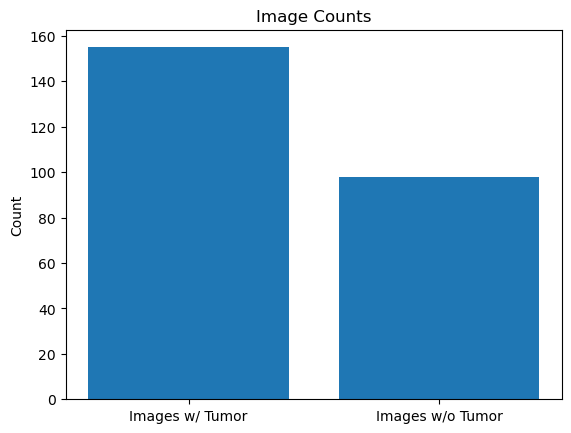

In [14]:
import glob


imagesyes = glob.glob('Data/yes/*')
imagesno = glob.glob('Data/no/*')

imgcounts = [len(imagesyes),len(imagesno)]

plt.bar(['Images w/ Tumor','Images w/o Tumor'],imgcounts)
plt.ylabel('Count')
plt.title('Image Counts')
plt.show()

In [16]:

train_data, test_data = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=50,
    validation_split=.2,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
    #pad_to_aspect_ratio=False,
    #data_format=None,
    #verbose=True,
)

j = train_data.as_numpy_iterator()
flt = []
for w in j: #7 batches in train set, 32 images in a batch, 256 pixels high, 256 pixels wide, 3 channels
  numInBatch = w[0].shape[0]
  flt = np.append(flt,w[0][0:numInBatch].flatten()) #w[0][0] give us the shape of the first image in the first batch
  flt = np.array(flt).flatten()
print(np.array(flt).shape)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Using 50 files for validation.
(39911424,)


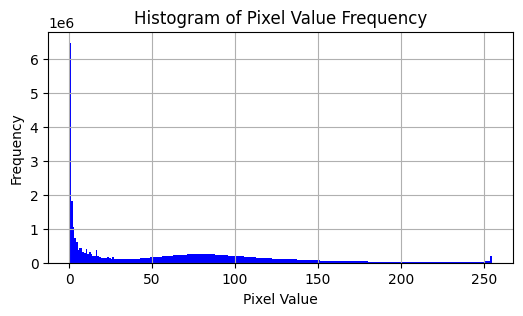

In [17]:
pixels = flt

plt.figure(figsize=(6, 3))
plt.hist(pixels, bins=256, color='blue')
plt.title('Histogram of Pixel Value Frequency')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+

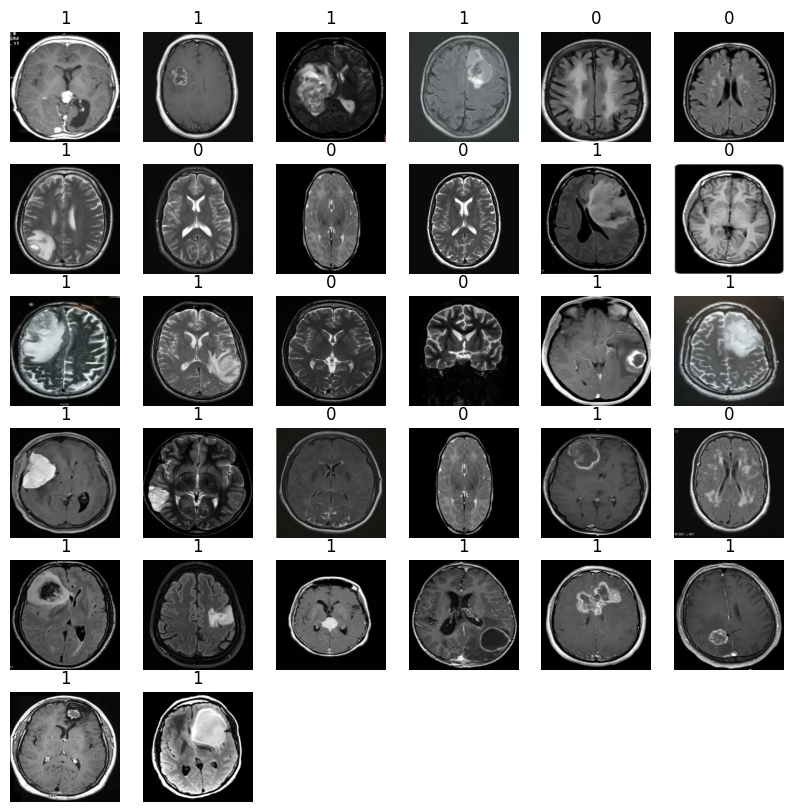

In [18]:

r = 0

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(3):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"), cmap="gray")
        plt.title(int(labels[i]))
        plt.axis("off")

        if(r==0):
            print(images[i][25])
            r = 1
#plt.imshow(np.array(i.).astype("uint8"))

__4.) Model Building/Model Choice__

*Use multiple models and give reasonings for model choices.*

As we have images and are doing a binary classification on whether or not the image contains a tumor and since this is the 3rd mini-project in our course we will use a CNN->ANN model for this classification task. There are unlimited options when building a CNN->ANN model, there are unlimited combinations of layers we could use. Due to the data limits on Google Colab, I was only able to play around for a little while on combinations of layers before Google kicked me off the GPUs. I found that having around 6 convolutional layers was giving me decent enough results.

For a comparison model due to our low number of images I have also included a K-Means model to see if we have any success classifying the images in an unsupervised way. It will be interesting to see if a simpler KMeans model can perform close to or better than a complex neural network.

The reasoning for these model selections are because CNN's are great for image data and KMeans because I believe it will be not very great at this task due to the limitations of classes as it's binary and KMeans won't be able to find enough similarity with only two clusters to distinguish between whether or not the image contains a tumor.

In [20]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

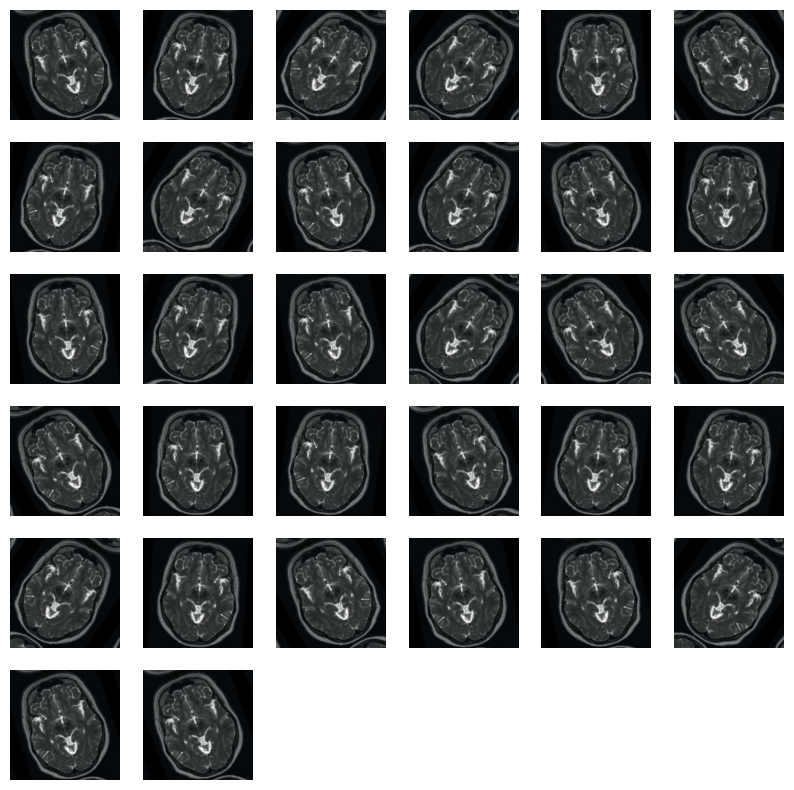

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(32):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"), cmap="gray")
        plt.axis("off")

In [22]:
train_data = train_data.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_data = train_data.prefetch(tf_data.AUTOTUNE)
test_data = test_data.prefetch(tf_data.AUTOTUNE)

print(tf_data.experimental.cardinality(train_data).numpy())

7


tf.Tensor(
[[1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]

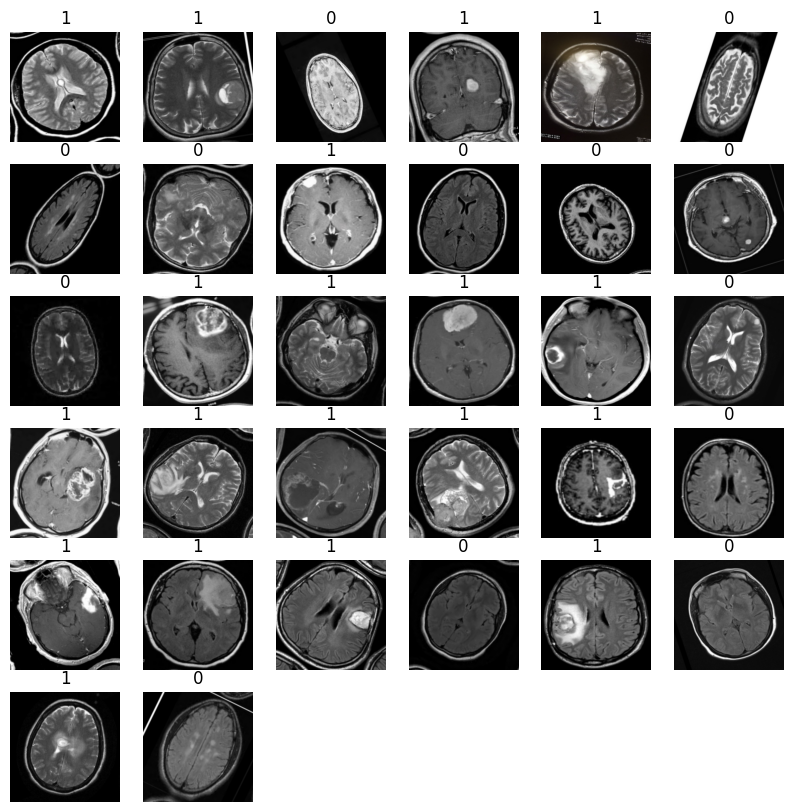

In [23]:
r = 0

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"), cmap="gray")
        plt.title(int(labels[i]))
        plt.axis("off")

        if(r==0):
            print(images[i][25])
            r = 1

In [24]:
from keras.layers import Conv2D, Dense
from keras.models import Sequential



model1CNN = Sequential()

inp_shape = (256,256,3)

model1CNN.add(keras.Input(shape=inp_shape))
model1CNN.add(keras.layers.Rescaling(1./255))

model1CNN.add(Conv2D(32, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

model1CNN.add(Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

model1CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

model1CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

model1CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

model1CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
model1CNN.add(keras.layers.BatchNormalization())
model1CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))



model1CNN.add(keras.layers.Flatten())
model1CNN.add(Dense(128,activation="relu"))
model1CNN.add(keras.layers.Dropout(.5))
model1CNN.add(Dense(1,activation="sigmoid"))





In [25]:


model1CNN.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',
    metrics=[
        'acc'
        #keras.metrics.FalseNegatives(),
    ])

__5.) Model Training__

*Show model training procedure and hyperparameter tuning. Show any procedure for measuring train and/or test performances*

I started with 3 convolutional layers and didn't get great results with accuracies topping out around 63% on the training data. I doubled the convolutional layers and added batch normalization and max pooling to each layer and was able to get the training accuracy up to 98% percent and higher on different runs. I will discuss the test predictions in the results and analysis section. You can see the model training epochs below.

I focused my hyperparameter tuning on the CNN model. In order to make this somewhat efficient and not use up the limited GPU availability on Google Colab I limited this to checking different number of filters and stride on the first convolutional layer and then learning rate on the entire model. I used the keras_tuner, link to docs here: https://keras.io/guides/keras_tuner/getting_started/, to run a shortened fitting of the models. The results from the best model are printed below the original model.

For the KMeans model I actually did it a bit different EDA-wise than the CNN model. I flattened the images into grayscale numpy arrays and then fed them into a KMeans model. So the biggest hurdle their was getting the arrays flattened from the directories and folders. Then I had to configure some label permutation functions to work on th resulting data. The results from the predictions are printed out as are the best permutation of labels and accuracy.

In [26]:
model1CNN = model1CNN.fit(
    train_data,
    epochs=50,
    validation_data=test_data,
)

Epoch 1/50
7/7 [==============================] - 8s 268ms/step - loss: 1.0031 - acc: 0.6897 - val_loss: 0.6652 - val_acc: 0.6200
Epoch 2/50
7/7 [==============================] - 2s 172ms/step - loss: 0.5712 - acc: 0.7143 - val_loss: 0.6516 - val_acc: 0.6200
Epoch 3/50
7/7 [==============================] - 2s 178ms/step - loss: 0.5097 - acc: 0.7438 - val_loss: 0.6268 - val_acc: 0.6200
Epoch 4/50
7/7 [==============================] - 3s 265ms/step - loss: 0.3972 - acc: 0.8276 - val_loss: 0.6456 - val_acc: 0.6000
Epoch 5/50
7/7 [==============================] - 2s 190ms/step - loss: 0.4803 - acc: 0.7635 - val_loss: 0.6561 - val_acc: 0.6000
Epoch 6/50
7/7 [==============================] - 2s 171ms/step - loss: 0.3587 - acc: 0.8522 - val_loss: 0.6175 - val_acc: 0.6200
Epoch 7/50
7/7 [==============================] - 2s 183ms/step - loss: 0.3905 - acc: 0.8079 - val_loss: 0.6312 - val_acc: 0.6000
Epoch 8/50
7/7 [==============================] - 2s 179ms/step - loss: 0.4072 - acc: 0.83

In [29]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00 0:00:01


In [32]:
import keras_tuner

def build_model(hp):
  model2CNN = Sequential()

  inp_shape = (256,256,3)

  model2CNN.add(keras.Input(shape=inp_shape))
  model2CNN.add(keras.layers.Rescaling(1./255))

  model2CNN.add(Conv2D(filters=hp.Int("filters", min_value=32, max_value=128, step=32) , kernel_size=3, strides=hp.Int("stride",min_value=1, max_value=2, step=1), padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

  model2CNN.add(Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

  model2CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

  model2CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

  model2CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))

  model2CNN.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu"))
  model2CNN.add(keras.layers.BatchNormalization())
  model2CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"))



  model2CNN.add(keras.layers.Flatten())
  model2CNN.add(Dense(128,activation="relu"))
  model2CNN.add(keras.layers.Dropout(.5))
  model2CNN.add(Dense(1,activation="sigmoid"))

  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model2CNN.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )

  return model2CNN


build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/",
    project_name="tuningResults",
)

tuner.search_space_summary()

tuner.search(train_data, epochs=2, validation_data=test_data)

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Trial 3 Complete [00h 00m 19s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.6000000238418579
Total elapsed time: 00h 01m 13s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64

In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import glob

directory = '/content/brain_tumor_dataset'

print(os.path.exists(directory))

#for KMeans we don't care about the labels for training, but we do need them for testing, so we should include them
imagesKMyes = glob.glob('/content/yes/*')
imgYes = [(cv2.resize(cv2.imread(pth, cv2.IMREAD_GRAYSCALE),(256,256)),1) for pth in imagesKMyes]

imagesKMno = glob.glob('/content/no/*')
imgNo = [(cv2.resize(cv2.imread(pth, cv2.IMREAD_GRAYSCALE),(256,256)),0) for pth in imagesKMno]
#for pth in imagesKMyes:
#  img = cv2.imread(pth, cv2.COLOR_RGB2GRAY)
#  imgYes.append((img,1))

#display(imgYes[5][0])
imgOnlyYes = [ (pix[0]/255.0).flatten() for pix in imgYes]
#print(imgOnlyYes[5])

imgOnlyNo= [ (pix[0]/255.0).flatten() for pix in imgNo]
#display((imgOnlyNo[5]*255).astype(np.uint8).reshape(256,256))
#display(imgNo[5][0])

allImages = imgYes + imgNo
flatAllImages = [(aImg[0].flatten(),aImg[1]) for aImg in allImages]
X = [flatimg[0] for flatimg in flatAllImages]
y = [flatimg[1] for flatimg in flatAllImages]
#print(y)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.2, random_state=42)

kmeansTumorIdentifier = KMeans(n_clusters=2,n_init="auto").fit(train_X)
print(kmeansTumorIdentifier.labels_)
print(train_y)


True
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0

In [109]:
import itertools
import functools
import operator

def label_permute_compare(ytdf,yp,n=2,denom=1):

    curBestAcc = 0.0
    curBestPerm = (0,0)
    #ytdf = ytdf.to_numpy()
    #actLabel = dict(map(lambda i,j : (i,j) , ['P', 'H'],[0,1]))
    #ytdf2 = list(map(lambda x: actLabel[x[0]],ytdf))
    for itp in itertools.permutations([0,1]):
        #Need to update the prediction output with different permutations
        yp2 = list(map(lambda x,y: 1 if itp[x]==y else 0, yp, ytdf))
        yp2Numerator = functools.reduce(operator.add, yp2)
        #print(yp2)
        #print(yp2Numerator)
        yp2Acc = yp2Numerator/denom #Updated denominator here to be number of samples

        if(yp2Acc > curBestAcc):
            curBestPerm = itp
            curBestAcc = yp2Acc
    return  curBestPerm, curBestAcc

In [110]:
bestperm,bestacc = label_permute_compare(train_y,kmeansTumorIdentifier.labels_,denom=len(train_y))

bestperm,bestacc

((0, 1), 0.5495049504950495)

In [100]:
final = kmeansTumorIdentifier.predict(test_X)
print(len(final))
print(len(test_y))

51
51


In [112]:
bestperm1,bestacc1 = label_permute_compare(test_y,final, denom=len(test_y))

bestperm1,bestacc1

((0, 1), 0.6862745098039216)

__6.) Results and Analysis__

*Does it have a summary of results and analysis? <br>*
*Does it have a proper visualization? (e.g., tables, graphs/plots, heat maps, statistics summary with interpretation, etc) <br>*
*Does it use different kinds of evaluation metrics properly? Also, does it explain why they chose the metric? <br>*
*Does it iterate the training and evaluation process and improve the performance? Does it address selecting features through the iteration process? <br>*
*Did the author compare the results from the multiple models and make appropriate comparisons?*

The results from my CNN->ANN model were very interesting. I was able to attain high training accuracy with around 6 convolutional layers and some other layers including Batch Normalization and Max Pooling. I was a bit limited by Google Colab, reaching my data limits multiple times, which limited my ability to further tune the model or try some others via transfer learning. Occasionally I would get a decent test accuracy on the test set, but I'm not totally shocked that it wasn't higher as the test set was fairly small. The whole training might've performed better on a larger dataset.

We see below how the training accuracy increased and the training loss diminished with more epochs. The testing data was a little more volatile, again this is probably due to the limited dataset.

For the KMeans model, I included a confusion matrix of the results, showing around a 68.6% accuracy score. I also included the F1 score which was .6. I don't believe the accuracy is better than guessing for this part. I believe one of the main reasons for this is that KMeans probably wasn't grouping these by whether or not there was a tumor. It would be looking more at the similarity between the entire image, so two images with tumors in different locations might not get clustered together. 

Comparing the CNN->ANN and KMeans models for this task a bit of an apples to oranges comparison. The CNN->ANN is much more equipped to handle a task like this; however, I'm sure with enough persistence one could find a way to adapt KMeans to work on this sort of problem. One method I read about suggested using a large number of clusters for KMeans, even more than classification classes, which I then presume you would need to find a way to group those clusters. Anyway, for this type of task it seems the CNN->ANN model works well and is able to detect some of the features of some tumors. We could've used early stopping on the CNN->ANN model once we hit a test accuracy of 85% or so, sometimes that would've given as a performant model on both train and test data, but it was good to do more epochs to see how the accuracy changes and plateaus and sometimes degrades.

The hyperparameter tuning process was interesting, I wish I could've done more hyperparameters, but I was worried about Google Colab kicking me off the GPUs so I kept it limited, but still was able to get a pretty decent "best model".

All of the visuals described above are in the following cells.


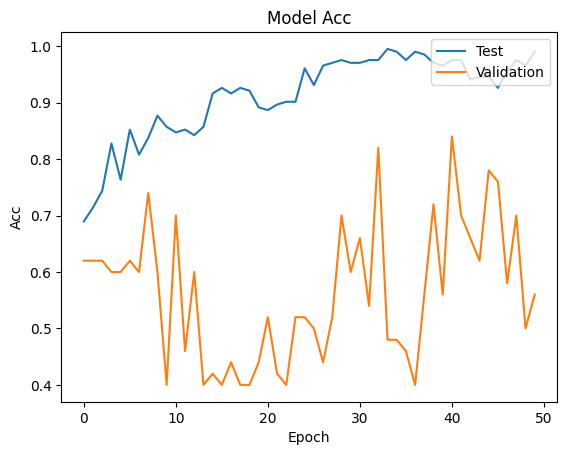

In [33]:
plt.plot(model1CNN.history['acc'])
plt.plot(model1CNN.history['val_acc'])
plt.title('Model Acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

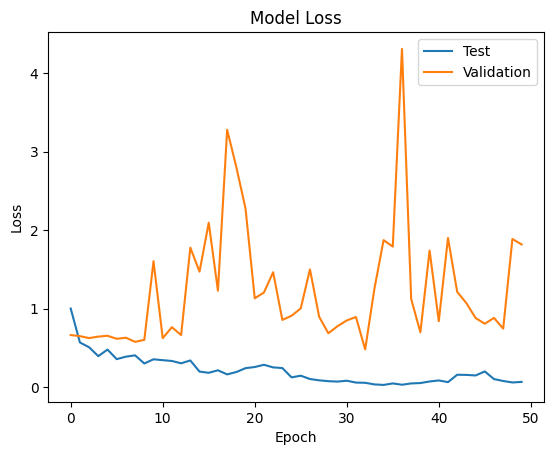

In [27]:
plt.plot(model1CNN.history['loss'])
plt.plot(model1CNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

<Figure size 800x500 with 0 Axes>

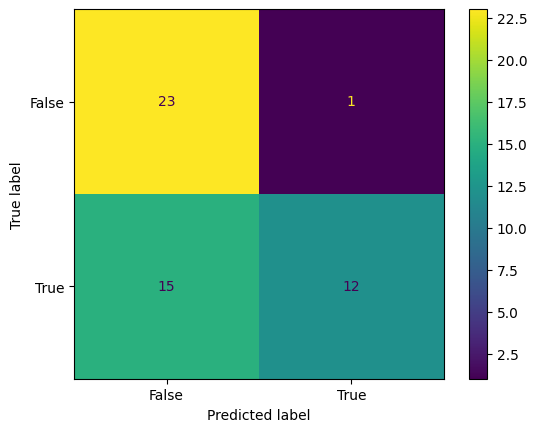

0.6

In [114]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics

cmkm = confusion_matrix(test_y,list(map(lambda x: bestperm1[x], final)))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmkm, display_labels = [False, True])
plt.figure(figsize = (8,5))
cm_display.plot()
plt.show()

display(f1_score(test_y, list(map(lambda x: bestperm1[x], final))))

__7.) Discussion and Conclusion__

*Add your discussion on the results, ways to improve the results*

To conclude this project it was very neat to see how to apply a Keras model to a dataset. With unlimited GPU use from Google, I do believe I could've found a better model. I do think there were some shortcomings with the dataset, mostly in that it is relatively small so not only are the training data limited, but any misclassification in the test data set is disproportionately large. Adding more images could've helped the results. Also there are potentially some other image processing techniques that could've enhanced the images, things like edge detection might've given the model more defined features. I think the addition of the keras_tuner for hyperparameter optimization was a win for this project. Given the layers of my model I believe it gives a good idea of how to set the hyperparameters for a more refined model. Thank you for taking the time to read my project!

__Works Cited__

Team, Keras. “Keras Documentation: Keras API Reference.” Keras.io, keras.io/api/.

Team, Keras. “Keras Documentation: Getting Started with KerasTuner.” Keras.io, keras.io/guides/keras_tuner/getting_started/.

“Data Augmentation | TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/images/data_augmentation.

Team, Keras, and fchollet. “Keras Documentation: Image Classification from Scratch.” Keras.io, keras.io/examples/vision/image_classification_from_scratch/.